# Capstone Project

## The Battle of Neighbourhoods - Finding the most suitable place in Toronto

by _Yi Zhang_

### 0. Install dependencies

In [58]:
!pip install geocoder
!pip install folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


### 1. Import libararies

In [59]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


### 2. Data Extraction and Cleaning

Postal codes data

In [60]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(url)
html_doc = response.text
soup = BeautifulSoup(html_doc, 'html.parser')
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        # cell['Neighbourhood'] = (((((row.span.text).split('(')[1:]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        borough_list = (row.span.text).split('(')[1:]
        borough_list = [x.replace(' /', ',').replace(')',' ').strip(' ') for x in borough_list]
        cell['Neighbourhood'] = ', '.join(borough_list)
        table_contents.append(cell)

In [61]:
df = pd.DataFrame(table_contents)
assert(df[df['Borough'] == 'Not assigned'].shape == (0, 3))
assert(df[df['Neighbourhood'] == 'Not assigned'].shape == (0, 3))

In [62]:
df.shape

(103, 3)

In [63]:
df.head()

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [64]:
df.describe()

,PostalCode,Borough,Neighbourhood
count,103,103,103
unique,103,15,103
top,M9B,North York,The Danforth East
freq,1,24,1


In [65]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords

In [66]:
# Retrieving Postal Code Co-ordinates
postal_codes = df['PostalCode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [67]:
# Adding Latitude, Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [68]:
df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Queen's Park,Ontario Provincial Government,43.66253,-79.39188


Adding real state average price

In [69]:
# The code was removed by Watson Studio for sharing.

,Postal Code,Average Price
0,M2L,"$7,884,017"
1,M4Y,"$5,149,990"
2,M4W,"$5,133,057"
3,M3B,"$4,940,245"
4,M2P,"$4,291,286"


In [70]:
df_wp = df.join(df_price.set_index('Postal Code'), on='PostalCode') # df_wp means dataframe with price

In [71]:
df_wp = df_wp[~df_wp['Average Price'].isna()].reset_index(drop=True)

In [72]:
df_wp.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Average Price
0,M3A,North York,Parkwoods,43.75245,-79.32991,"$1,789,792"
1,M4A,North York,Victoria Village,43.73057,-79.31306,"$1,248,904"
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,"$1,691,184"
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,"$1,939,437"
4,M9A,Etobicoke,Islington Avenue,43.66263,-79.52831,"$2,456,182"


In [73]:
df_wp.shape

(94, 6)

In [74]:
# convert string to int
df_wp['Average Price($)']=df_wp['Average Price'].str.replace('$','').str.replace(',','').astype(int)

In [75]:
df_wp.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Average Price,Average Price($)
0,M3A,North York,Parkwoods,43.75245,-79.32991,"$1,789,792",1789792
1,M4A,North York,Victoria Village,43.73057,-79.31306,"$1,248,904",1248904
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,"$1,691,184",1691184
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,"$1,939,437",1939437
4,M9A,Etobicoke,Islington Avenue,43.66263,-79.52831,"$2,456,182",2456182


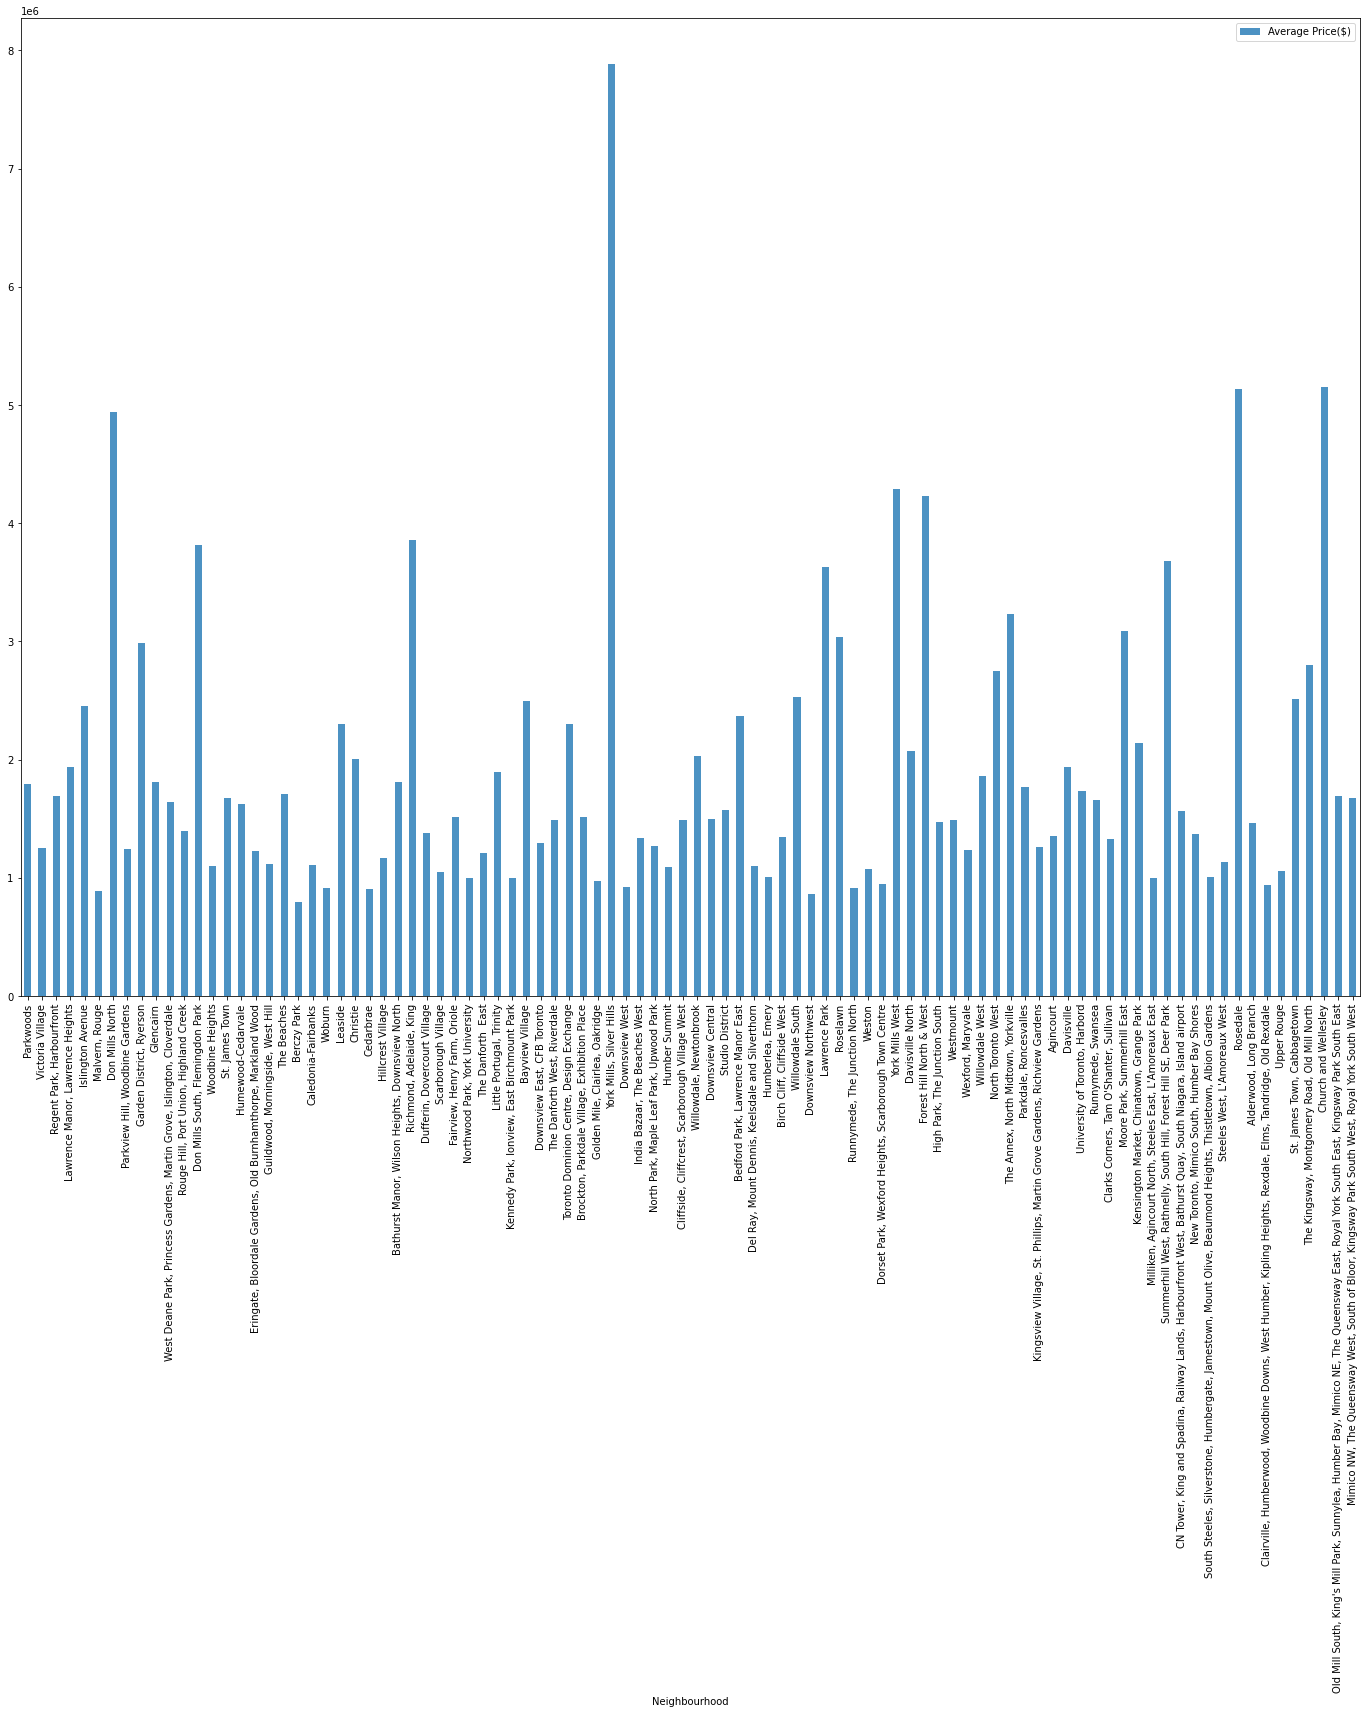

In [76]:
# plot the average housing price as a bar chart
df_wp.iloc[:,[0,2,6]].set_index('Neighbourhood',drop=True).plot(kind='bar', figsize=(24,18), alpha=0.8)

Generating map of Toronto

In [77]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="IBM Watson Studio")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of {} are {}, {}.'.format(address, latitude_x, longitude_y))

The Geograpical Co-ordinate of Toronto, Ontario are 43.6534817, -79.3839347.


Map of Toronto

In [78]:
map_Toronto = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei, ahp, in zip(df_wp['Latitude'], df_wp['Longitude'], df_wp['Neighbourhood'], df_wp['Average Price']):
    
    label = '{} | {}'.format(nei, ahp)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)

In [79]:
map_Toronto

Mining most common venues near neighborhoods via Foursquare API

In [80]:
# The code was removed by Watson Studio for sharing.

In [81]:
def getNearbyVenues(names, latitudes, longitudes, radius=radius, limit=LIMIT, explorer_pattern=explorer_pattern):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = explorer_pattern.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [82]:
# Nearby Venues with respect to neighbourhoods

Toronto_venues = getNearbyVenues(names=df_wp['Neighbourhood'],
                                   latitudes=df_wp['Latitude'],
                                   longitudes=df_wp['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South, Flemingdon Park
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East, CFB Toronto
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, 

In [83]:
print('There are {} Uniques Categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 333 Uniques Categories.


In [84]:
Toronto_venues.groupby('Neighbourhood').count().head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,41,41,41,41,41,41
"Alderwood, Long Branch",28,28,28,28,28,28
"Bathurst Manor, Wilson Heights, Downsview North",34,34,34,34,34,34
Bayview Village,7,7,7,7,7,7
"Bedford Park, Lawrence Manor East",36,36,36,36,36,36


One hot Encoding of Features

In [85]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighbourhood'] = Toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]
Toronto_grouped = Toronto_onehot.groupby('Neighbourhood').mean().reset_index()
Toronto_sum = Toronto_onehot.groupby('Neighbourhood').sum().reset_index()

In [86]:
Toronto_grouped.head(5)

,Neighbourhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop

In [87]:
Toronto_sum.head(5)

,Neighbourhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop

In [88]:
education_cols = [x for x in list(Toronto_sum.keys()) if 'school' in x.lower()]

In [89]:
education_cols

['Elementary School', 'Martial Arts School', 'Music School', 'School']

In [90]:
Toronto_edu = Toronto_sum[['Neighbourhood']+education_cols]

In [91]:
Toronto_edu['num of school'] = Toronto_edu.sum(axis=1)

Find most Common Venues near neighborhood

In [92]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [93]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = Toronto_grouped['Neighbourhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Sandwich Place,Pool,Seafood Restaurant,Sushi Restaurant,Supermarket,Latin American Restaurant,Lounge,Breakfast Spot
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Bank,Pharmacy,Park,Sandwich Place,Beer Store,Bar,Seafood Restaurant,Liquor Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Pizza Place,Gas Station,Bank,Coffee Shop,Park,Bridal Shop,Trail,Supermarket,Sandwich Place,Sushi Restaurant
3,Bayview Village,Park,Café,Japanese Restaurant,Bank,Trail,Chinese Restaurant,Fish & Chips Shop,Financial or Legal Service,Elementary School,Food
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Pet Store,Juice Bar,Sandwich Place,Bridal Shop,Pharmacy,Liquor Store,Sports Club,Intersection


Categorize the average housing price

In [94]:
df_wp['price_tier'] = pd.cut(x=df_wp['Average Price($)'], bins=[0, 1e6, 2e6, 3e6, 4e6, 5e6, np.inf], labels=['<1M', '1M-2M', '2M-3M', '3M-4M', '4M-5M', '>5M'])

In [95]:
df_wp.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Average Price,Average Price($),price_tier
0,M3A,North York,Parkwoods,43.75245,-79.32991,"$1,789,792",1789792,1M-2M
1,M4A,North York,Victoria Village,43.73057,-79.31306,"$1,248,904",1248904,1M-2M
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,"$1,691,184",1691184,1M-2M
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,"$1,939,437",1939437,1M-2M
4,M9A,Etobicoke,Islington Avenue,43.66263,-79.52831,"$2,456,182",2456182,2M-3M


Join the df_wp to Toronto_sum

In [100]:
df_wp_final = df_wp.join(Toronto_edu[['Neighbourhood', 'num of school']].set_index('Neighbourhood'), on='Neighbourhood').dropna().reset_index(drop=True)

Appling K-means on Toronto_grouped

In [109]:
df_clustering = Toronto_grouped.drop('Neighbourhood', 1)


In [110]:
df_clustering.shape

(93, 333)

Optimizing K values

In [121]:
Sum_of_squared_distances = []
K = range(3,11)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(df_clustering)
    Sum_of_squared_distances.append(km.inertia_)

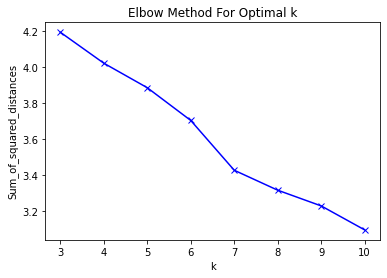

In [122]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Looks like k = 7 is a good Elbow-point

In [123]:
best_kmeans = KMeans(n_clusters=7, random_state=0).fit(df_clustering)

In [124]:
best_kmeans.labels_

array([2, 2, 2, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2,
       1, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 5, 3, 2, 0, 2, 2, 0, 2,
       0, 0, 0, 0, 6, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 1, 2, 4, 0,
       2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2,
       0, 2, 2, 0, 1], dtype=int32)

In [125]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', best_kmeans.labels_)

In [126]:
neighbourhoods_venues_sorted.head()

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Agincourt,Chinese Restaurant,Shopping Mall,Sandwich Place,Pool,Seafood Restaurant,Sushi Restaurant,Supermarket,Latin American Restaurant,Lounge,Breakfast Spot
1,2,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Bank,Pharmacy,Park,Sandwich Place,Beer Store,Bar,Seafood Restaurant,Liquor Store
2,2,"Bathurst Manor, Wilson Heights, Downsview North",Pizza Place,Gas Station,Bank,Coffee Shop,Park,Bridal Shop,Trail,Supermarket,Sandwich Place,Sushi Restaurant
3,1,Bayview Village,Park,Café,Japanese Restaurant,Bank,Trail,Chinese Restaurant,Fish & Chips Shop,Financial or Legal Service,Elementary School,Food
4,0,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Pet Store,Juice Bar,Sandwich Place,Bridal Shop,Pharmacy,Liquor Store,Sports Club,Intersection


Join the df_wp_final to neighbourhoods_venues_sorted

In [127]:
df_final = df_wp_final.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

In [128]:
df_final.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Average Price,Average Price($),price_tier,num of school,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.75245,-79.32991,"$1,789,792",1789792,1M-2M,0.0,2,Park,Bus Stop,ATM,Café,Supermarket,Food & Drink Shop,Fish & Chips Shop,Fast Food Restaurant,Skating Rink,Shop & Service
1,M4A,North York,Victoria Village,43.73057,-79.31306,"$1,248,904",1248904,1M-2M,0.0,2,Middle Eastern Restaurant,Portuguese Restaurant,Thrift / Vintage Store,Pizza Place,Coffee Shop,Park,Medical Supply Store,Thai Restaurant,Mediterranean Restaurant,Hockey Arena
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,"$1,691,184",1691184,1M-2M,0.0,0,Coffee Shop,Restaurant,Café,Park,Theater,Italian Restaurant,Pub,Bakery,Thai Restaurant,Sushi Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,"$1,939,437",1939437,1M-2M,0.0,0,Clothing Store,Restaurant,Coffee Shop,Furniture / Home Store,Dessert Shop,Fast Food Restaurant,Gym,Men's Store,Metro Station,Fried Chicken Joint
4,M9A,Etobicoke,Islington Avenue,43.66263,-79.52831,"$2,456,182",2456182,2M-3M,0.0,2,Bank,Shopping Mall,Pharmacy,Liquor Store,Grocery Store,Skating Rink,Supermarket,Bakery,Café,Escape Room


Visualizing the map of clusters

In [132]:
kclusters = 7

In [133]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei, pt, nos, cluster in zip(df_final['Latitude'], 
                                   df_final['Longitude'], 
                                   df_final['Neighbourhood'],
                                   df_final['price_tier'],
                                   df_final['num of school'],
                                   df_final['Cluster Labels']):
    label = folium.Popup('{} : price tier [{}] #schools [{}] >> Cluster {}'.format(nei, pt, nos, str(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#2c7ef7', '#2adddd', '#80ffb4', '#d4dd80', '#ff7e41', '#ff0000']


Observing the members in clusters

In [134]:
from IPython.core import display as ICD
for c in range(kclusters):
    print('Cluster {}'.format(c))
    ICD.display(df_final.loc[df_final['Cluster Labels'] == c, df_final.columns[[1] + [7, 8] + list(range(10, df_final.shape[1]))]])

Cluster 0


,Borough,price_tier,num of school,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,1M-2M,0.0,Coffee Shop,Restaurant,Café,Park,Theater,Italian Restaurant,Pub,Bakery,Thai Restaurant,Sushi Restaurant
3,North York,1M-2M,0.0,Clothing Store,Restaurant,Coffee Shop,Furniture / Home Store,Dessert Shop,Fast Food Restaurant,Gym,Men's Store,Metro Station,Fried Chicken Joint
6,North York,4M-5M,0.0,Coffee Shop,Bank,Electronics Store,Restaurant,Juice Bar,Bagel Shop,Salad Place,Gas Station,Supermarket,Italian Restaurant
8,Downtown Toronto,2M-3M,0.0,Coffee Shop,Japanese Restaurant,Gastropub,Café,Theater,Italian Restaurant,Cosmetics Shop,Middle Eastern Restaurant,Thai Restaurant,Bookstore
12,North York,3M-4M,0.0,Gym,Coffee Shop,Restaurant,Park,Clothing Store,Italian Restaurant,Other Great Outdoors,Office,Sandwich Place,Chinese Restaurant
14,Downtown Toronto,1M-2M,0.0,Coffee Shop,Café,Restaurant,Italian Restaurant,Gastropub,Seafood Restaurant,Cosmetics Shop,Japanese Restaurant,Plaza,Hotel
18,East Toronto,1M-2M,1.0,Pub,Park,Coffee Shop,Breakfast Spot,Burger Joint,Pizza Place,Bar,Bakery,BBQ Joint,Thai Restaurant
19,Downtown Toronto,<1M,0.0,Coffee Shop,Café,Restaurant,Japanese Restaurant,Park,Beer Bar,Hotel,Farmers Market,Pharmacy,Gym
22,East York,2M-3M,0.0,Coffee Shop,Sporting Goods Shop,Grocery Store,Furniture / Home Store,Electronics Store,Brewery,Bank,Burger Joint,Sports Bar,Restaurant
23,Downtown Toronto,2M-3M,1.0,Korean Restaurant,Café,Grocery Store,Coffee Shop,Mexican Restaurant,Ice Cream Shop,Cocktail Bar,Comedy Club,Indian Restaurant,Caribbean Restaurant


Cluster 1


,Borough,price_tier,num of school,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,North York,2M-3M,0.0,Park,Café,Japanese Restaurant,Bank,Trail,Chinese Restaurant,Fish & Chips Shop,Financial or Legal Service,Elementary School,Food
41,North York,>5M,0.0,Park,Gym,Gym / Fitness Center,Intersection,Farmers Market,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space
48,North York,1M-2M,0.0,Park,Outdoor Supply Store,Home Service,Construction & Landscaping,Baseball Field,Bus Stop,Farmers Market,Elementary School,Escape Room,Ethiopian Restaurant
53,Scarborough,1M-2M,0.0,Park,General Entertainment,Skating Rink,Thai Restaurant,Ice Cream Shop,Gym,College Stadium,Restaurant,Gym Pool,Diner
85,Downtown Toronto,>5M,0.0,Park,Neighborhood,Trail,Sporting Goods Shop,Grocery Store,Candy Store,Athletics & Sports,Kids Store,Playground,Filipino Restaurant


Cluster 2


,Borough,price_tier,num of school,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,1M-2M,0.0,Park,Bus Stop,ATM,Café,Supermarket,Food & Drink Shop,Fish & Chips Shop,Fast Food Restaurant,Skating Rink,Shop & Service
1,North York,1M-2M,0.0,Middle Eastern Restaurant,Portuguese Restaurant,Thrift / Vintage Store,Pizza Place,Coffee Shop,Park,Medical Supply Store,Thai Restaurant,Mediterranean Restaurant,Hockey Arena
4,Etobicoke,2M-3M,0.0,Bank,Shopping Mall,Pharmacy,Liquor Store,Grocery Store,Skating Rink,Supermarket,Bakery,Café,Escape Room
7,East York,1M-2M,0.0,Brewery,Pizza Place,Bakery,Coffee Shop,Rock Climbing Spot,Soccer Stadium,Fast Food Restaurant,Café,Gastropub,Office
9,North York,1M-2M,0.0,Grocery Store,Pizza Place,Italian Restaurant,Gas Station,Restaurant,Park,Sandwich Place,Latin American Restaurant,Clothing Store,Bank
10,Etobicoke,1M-2M,0.0,Hotel,Convenience Store,Pizza Place,Park,Restaurant,Grocery Store,Gym,Clothing Store,Bank,Mexican Restaurant
13,East York,1M-2M,0.0,Coffee Shop,Grocery Store,Pizza Place,Ice Cream Shop,Sushi Restaurant,Bar,Park,Bank,Bakery,Café
15,York,1M-2M,0.0,Coffee Shop,Pizza Place,Convenience Store,Grocery Store,Hockey Arena,Rental Service,Bagel Shop,Bakery,Bank,Middle Eastern Restaurant
16,Etobicoke,1M-2M,0.0,Pizza Place,Pet Store,Coffee Shop,Baseball Field,Pharmacy,College Rec Center,Convenience Store,Sandwich Place,Grocery Store,Café
17,Scarborough,1M-2M,0.0,Convenience Store,Park,Sports Bar,Restaurant,Supermarket,Discount Store,Grocery Store,Coffee Shop,Athletics & Sports,Gym / Fitness Center


Cluster 3


,Borough,price_tier,num of school,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
52,North York,1M-2M,0.0,Coffee Shop,Discount Store,Nightclub,Grocery Store,Café,Latin American Restaurant,Fish & Chips Shop,Flower Shop,Escape Room,Food


Cluster 4


,Borough,price_tier,num of school,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Scarborough,1M-2M,0.0,Italian Restaurant,Burger Joint,Park,Breakfast Spot,Flower Shop,Food,Escape Room,Food & Drink Shop,Ethiopian Restaurant,Event Space


Cluster 5


,Borough,price_tier,num of school,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,North York,1M-2M,0.0,Skating Rink,Pizza Place,Arts & Crafts Store,Café,Electronics Store,Zoo Exhibit,Farmers Market,Escape Room,Ethiopian Restaurant,Event Space


Cluster 6


,Borough,price_tier,num of school,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Scarborough,<1M,0.0,Zoo Exhibit,Fast Food Restaurant,Trail,Hobby Shop,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm


Conclusion:

- Cluster 0: downtown with high living cost or crowded space. A reversed 'T' formed region can be obviously discovered. The price tier of this region is about 1M-3M.
- Cluster 1: Luxus areas. The price tier can approach to '>5M'
- Cluster 2: Mid-high living cost. it is teared apart by Cluster 0 from the middle.
- Cluster 3-7: neighbours far away from the center with different features.